In [2]:
import csv
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from gtda.time_series import SingleTakensEmbedding, takens_embedding_optimal_parameters
import plotly.graph_objects as go
from gtda.plotting import plot_point_cloud
from nolitsa import dimension, delay
from sklearn.decomposition import PCA
import gudhi as gd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import kmapper as km


# LIMPIEZA

In [3]:
df = pd.read_csv("DATOSSUREÑOS.csv")##########MEDIDAS OCÉANICAS
das = pd.read_csv("PerthTemperatures.csv")####MEDIDAS TERRESTRES

df.head()

,Year,DJF,JFM,FMA,MAM,AMJ,MJJ,JJA,JAS,ASO,SON,OND,NDJ
0,1950,-1.5,-1.3,-1.2,-1.2,-1.1,-0.9,-0.5,-0.4,-0.4,-0.4,-0.6,-0.8
1,1951,-0.8,-0.5,-0.2,0.2,0.4,0.6,0.7,0.9,1.0,1.2,1.0,0.8
2,1952,0.5,0.4,0.3,0.3,0.2,0.0,-0.1,0.0,0.2,0.1,0.0,0.1
3,1953,0.4,0.6,0.6,0.7,0.8,0.8,0.7,0.7,0.8,0.8,0.8,0.8
4,1954,0.8,0.5,0.0,-0.4,-0.5,-0.5,-0.6,-0.8,-0.9,-0.8,-0.7,-0.7


In [4]:
das.head()

,Year,Month,Day,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres),Quality
0,1944,6,3,11.0,22.3,0.0,N
1,1944,6,4,12.2,23.4,0.0,Y
2,1944,6,5,12.0,20.3,2.0,Y
3,1944,6,6,7.4,18.7,3.3,Y
4,1944,6,7,5.9,21.3,0.3,Y


In [5]:
df.isnull().sum()


Year    0
DJF     0
JFM     0
FMA     0
MAM     0
AMJ     0
MJJ     0
JJA     0
JAS     0
ASO     0
SON     0
OND     0
NDJ     0
dtype: int64

In [6]:
das.isnull().sum()

Year                               0
Month                              0
Day                                0
Minimum temperature (Degree C)    76
Maximum temperature (Degree C)    30
Rainfall amount (millimetres)      0
Quality                           30
dtype: int64

In [7]:
# Rellenar valores nulos con el promedio de los valores anteriores
das_filled = das.fillna(method='ffill')

C:\Users\ivana\AppData\Local\Temp\ipykernel_43552\1126674144.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  das_filled = das.fillna(method='ffill')


In [8]:
# Verificar si quedan valores nulos después del relleno
print(das_filled.isnull().sum())

Year                              0
Month                             0
Day                               0
Minimum temperature (Degree C)    0
Maximum temperature (Degree C)    0
Rainfall amount (millimetres)     0
Quality                           0
dtype: int64


In [9]:
# Verificar que los datos se hayan llenado correctamente
print(das_filled.head())

   Year  Month  Day  Minimum temperature (Degree C)  \
0  1944      6    3                            11.0   
1  1944      6    4                            12.2   
2  1944      6    5                            12.0   
3  1944      6    6                             7.4   
4  1944      6    7                             5.9   

   Maximum temperature (Degree C)  Rainfall amount (millimetres) Quality  
0                            22.3                            0.0       N  
1                            23.4                            0.0       Y  
2                            20.3                            2.0       Y  
3                            18.7                            3.3       Y  
4                            21.3                            0.3       Y  


In [10]:
das_ = das_filled.drop(columns=['Day',"Quality"],)

In [11]:
das_.head()


,Year,Month,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
0,1944,6,11.0,22.3,0.0
1,1944,6,12.2,23.4,0.0
2,1944,6,12.0,20.3,2.0
3,1944,6,7.4,18.7,3.3
4,1944,6,5.9,21.3,0.3


In [43]:
# Agrupar por año y calcular el promedio de temperatura mínima, máxima y cantidad de lluvia
das_grouped = das_.groupby('Year').mean().reset_index()

# Seleccionar solo las columnas requeridas
das_final = das_grouped[['Year', 'Minimum temperature (Degree C)', 'Maximum temperature (Degree C)', 'Rainfall amount (millimetres)']]
# Convertir la columna "Year" a tipo datetime
das_final['Year'] = pd.to_datetime(das_final['Year'], format='%Y')

# Extraer solo el año de la columna "Year"
das_final['Year'] = das_final['Year'].dt.year

# Verificar el nuevo dataframe
print(das_final.head())
das_final.describe()

   Year  Minimum temperature (Degree C)  Maximum temperature (Degree C)  \
0  1944                        9.473585                       22.225472   
1  1945                       12.103288                       24.367945   
2  1946                       11.062192                       23.592877   
3  1947                       11.490959                       23.610137   
4  1948                       11.551093                       24.256831   

   Rainfall amount (millimetres)  
0                       2.382075  
1                       3.003288  
2                       2.674795  
3                       2.724384  
4                       2.160383  


C:\Users\ivana\AppData\Local\Temp\ipykernel_43552\1407994654.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ivana\AppData\Local\Temp\ipykernel_43552\1407994654.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Year,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
count,77.000000,77.000000,77.000000,77.000000
mean,1982.000000,12.167386,24.578581,2.063531
std,22.371857,0.943888,1.206361,0.457638
min,1944.000000,9.473585,22.225472,0.024390
25%,1963.000000,11.700548,23.915342,1.789041
50%,1982.000000,12.108493,24.433973,2.037808
75%,2001.000000,12.629315,25.119726,2.321918
max,2020.000000,17.097561,32.114634,3.190959


## VISUALIZACION DE LOS DATOS ANUALES DE LA TEMPERATURA DE TIERRA

#### CLUSTERIZAMOS CON RESPECTO A LAS LLUVIAS

0     3
1     4
2     4
3     4
4     3
     ..
72    2
73    3
74    3
75    2
76    0
Name: Cluster, Length: 77, dtype: int64


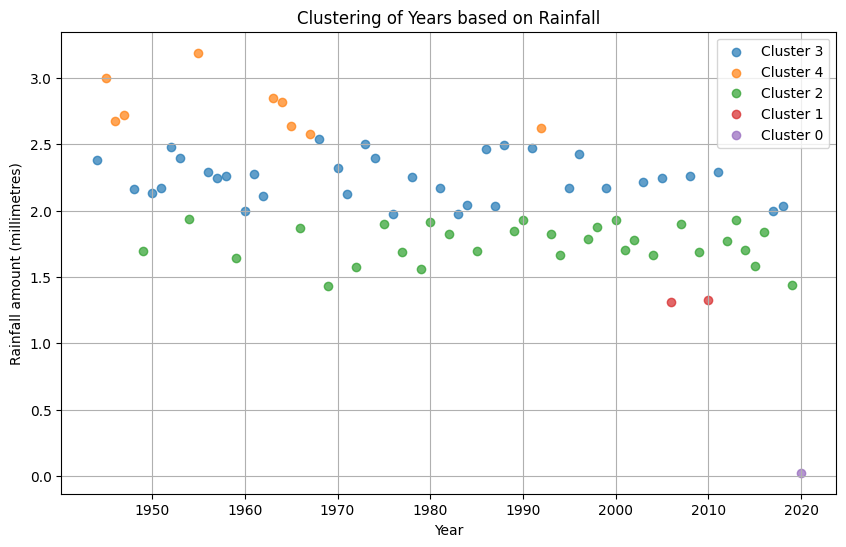

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from gtda.mapper import CubicalCover

# Definir la cantidad de cubiertas
num_bins = 5

# Crear los límites de las cubiertas basados en el rango de la cantidad de lluvia
bin_limits = np.linspace(das_final['Rainfall amount (millimetres)'].min(), das_final['Rainfall amount (millimetres)'].max(), num_bins + 1)

# Crear la cubierta cubical
cover = CubicalCover(n_intervals=num_bins)

# Obtener la matriz de datos para el clustering
X_cluster = np.array(das_final['Rainfall amount (millimetres)']).reshape(-1, 1)

# Aplicar la cubierta y obtener los clusters
cluster_labels = cover.fit_transform(X_cluster).argmax(axis=1)

# Agregar los clusters al dataframe das_final
das_final['Cluster'] = cluster_labels

print(das_final['Cluster'])
# Visualización de los clusters
plt.figure(figsize=(10, 6))
for cluster in das_final['Cluster'].unique():
    cluster_data = das_final[das_final['Cluster'] == cluster]
    plt.scatter(cluster_data['Year'], cluster_data['Rainfall amount (millimetres)'], label=f'Cluster {cluster}', alpha=0.7)
plt.xlabel('Year')
plt.ylabel('Rainfall amount (millimetres)')
plt.title('Clustering of Years based on Rainfall')
plt.legend()
plt.grid(True)
plt.show()


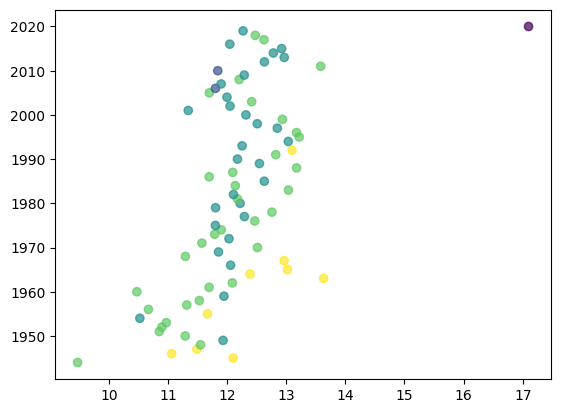

In [39]:
plt.scatter(das_final["Minimum temperature (Degree C)"], das_final["Year"], c=das_final["Cluster"])

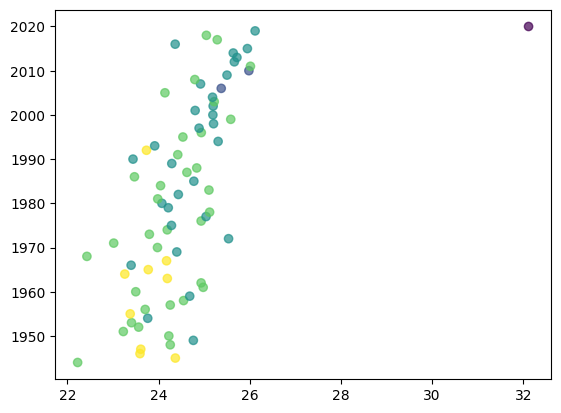

In [40]:
plt.scatter(das_final["Maximum temperature (Degree C)"], das_final["Year"], c=das_final["Cluster"])

In [16]:
nuevo_df = das_final.drop(columns=["Maximum temperature (Degree C)","Minimum temperature (Degree C)","Rainfall amount (millimetres)"])
nuevo_df.head()

,Year,Cluster
0,1944,3
1,1945,4
2,1946,4
3,1947,4
4,1948,3


In [17]:
for categoria in range(5):  
    datos_categoria = nuevo_df[nuevo_df['Cluster'] == categoria]
    print(f"\nDatos para la Cluster {categoria}:")
    print(datos_categoria)



Datos para la Cluster 0:
    Year  Cluster
76  2020        0

Datos para la Cluster 1:
    Year  Cluster
62  2006        1
66  2010        1

Datos para la Cluster 2:
    Year  Cluster
5   1949        2
10  1954        2
15  1959        2
22  1966        2
25  1969        2
28  1972        2
31  1975        2
33  1977        2
35  1979        2
36  1980        2
38  1982        2
41  1985        2
45  1989        2
46  1990        2
49  1993        2
50  1994        2
53  1997        2
54  1998        2
56  2000        2
57  2001        2
58  2002        2
60  2004        2
63  2007        2
65  2009        2
68  2012        2
69  2013        2
70  2014        2
71  2015        2
72  2016        2
75  2019        2

Datos para la Cluster 3:
    Year  Cluster
0   1944        3
4   1948        3
6   1950        3
7   1951        3
8   1952        3
9   1953        3
12  1956        3
13  1957        3
14  1958        3
16  1960        3
17  1961        3
18  1962        3
24  1968      

### MAPPER PARA VERIFICAR LAS CONEXIONES DE CLUSTER

In [18]:
import sklearn
# Normalizar los datos
scaler = StandardScaler()
cluster_data = scaler.fit_transform(das_final.iloc[:, 1:3])
# Crear un objeto Mapper
mapper = km.KeplerMapper(verbose=1)
# Mapear los datos
projected_data = mapper.fit_transform(cluster_data, projection=[0, 1])
#print(projected_data)
# Crear el grafo del Mapper
covering=km.Cover(n_cubes=7,perc_overlap=0.2)
covering


KeplerMapper(verbose=1)
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (77, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()



Cover(n_cubes=7, perc_overlap=0.2, limits=None, verbose=0)

In [19]:
graph = mapper.map(projected_data, cluster_data,  clusterer=sklearn.cluster.KMeans(n_clusters=5), cover=covering)

# Visualizar el grafo del Mapper
mapper.visualize(graph, path_html="mapperTEMPTERRA.html");

Mapping on data shaped (77, 2) using lens shaped (77, 2)

Creating 49 hypercubes.


c:\Users\ivana\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ivana\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ivana\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\ivana\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\


Created 26 edges and 35 nodes in 0:00:00.688719.
Wrote visualization to: mapperTEMPTERRA.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Kepler Mapper | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n  font-size: 13px;\n  font-weigh

In [20]:
graph["nodes"]


defaultdict(list,
            {'cube2_cluster0': [2, 7, 8, 9],
             'cube2_cluster1': [3, 11, 42],
             'cube2_cluster2': [24],
             'cube2_cluster3': [10, 12, 16],
             'cube2_cluster4': [27],
             'cube3_cluster0': [10, 12, 16],
             'cube3_cluster1': [4, 6, 13, 61],
             'cube3_cluster2': [3, 42],
             'cube3_cluster3': [2, 8],
             'cube3_cluster4': [14, 17, 57],
             'cube5_cluster0': [27],
             'cube5_cluster1': [22, 46],
             'cube5_cluster2': [11, 42],
             'cube5_cluster3': [20],
             'cube5_cluster4': [29],
             'cube6_cluster0': [34, 41, 47, 53],
             'cube6_cluster1': [4, 14, 25, 29, 30, 31, 35, 42, 61],
             'cube6_cluster2': [5, 15, 17, 18, 43, 58, 60, 63, 64],
             'cube6_cluster3': [1, 26, 36, 37, 38, 40, 45, 49, 72],
             'cube6_cluster4': [32, 33, 54, 56, 59, 74],
             'cube7_cluster0': [17, 18, 58, 60, 62, 63]

# ANALISIS DE TEMPERATURAS OCEANICAS

In [21]:

df.head()

# Convertir la columna 'Year' a tipo datetime
df['Year'] = pd.to_datetime(df['Year'], format='%Y')


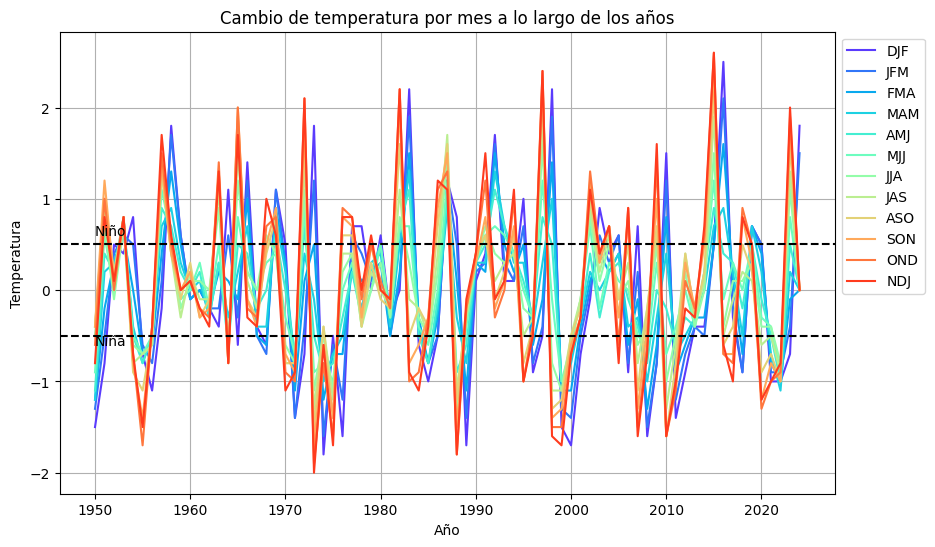

In [22]:

# Crear una gráfica para mostrar el cambio de temperatura para cada mes a lo largo de todos los años
plt.figure(figsize=(10, 6))

# Conjunto para almacenar etiquetas únicas
used_labels = set()

# Definir una paleta de colores categóricos
palette = sns.color_palette("rainbow", len(df.columns[1:]))

# Iterar sobre los meses y las columnas de temperatura
for month in range(1, 13):
    # Filtrar los datos para el mes actual
    month_data = df[df['Year'].dt.month == month]
    # Obtener la cantidad de datos para este mes
    num_data_points = month_data.shape[0]
    # Iterar sobre las columnas de temperatura y graficarlas si hay datos suficientes
    for i, col in enumerate(df.columns[1:]):
        # Verificar si la etiqueta ya se ha usado y si hay suficientes datos para graficar
        if col not in used_labels and num_data_points > 0:
            plt.plot(month_data['Year'], month_data[col], label=col, color=palette[i])
            used_labels.add(col)  # Agregar la etiqueta al conjunto de etiquetas usadas
    
# Configurar etiquetas y título
plt.xlabel('Año')
plt.ylabel('Temperatura')
plt.title('Cambio de temperatura por mes a lo largo de los años')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# Agregar líneas horizontales para los umbrales y etiquetar las regiones
plt.axhline(y=-0.5, color='black', linestyle='--', label='Umbral -0.5 (Niña)')
plt.axhline(y=0.5, color='black', linestyle='--', label='Umbral 0.5 (Niño)')

# Agregar texto para etiquetar las regiones
plt.text(df['Year'].iloc[0], -0.6, 'Niña', fontsize=10, color='black')
plt.text(df['Year'].iloc[0], 0.6, 'Niño', fontsize=10, color='black')

plt.show()

## ANALIZAMOS DE CERCA LA INFORMACIÓN DE CADA MES PARA PODER EMPATARLA CON EL INDICE DE LLUVIA Y TEMPERATURAS TERRESTRES

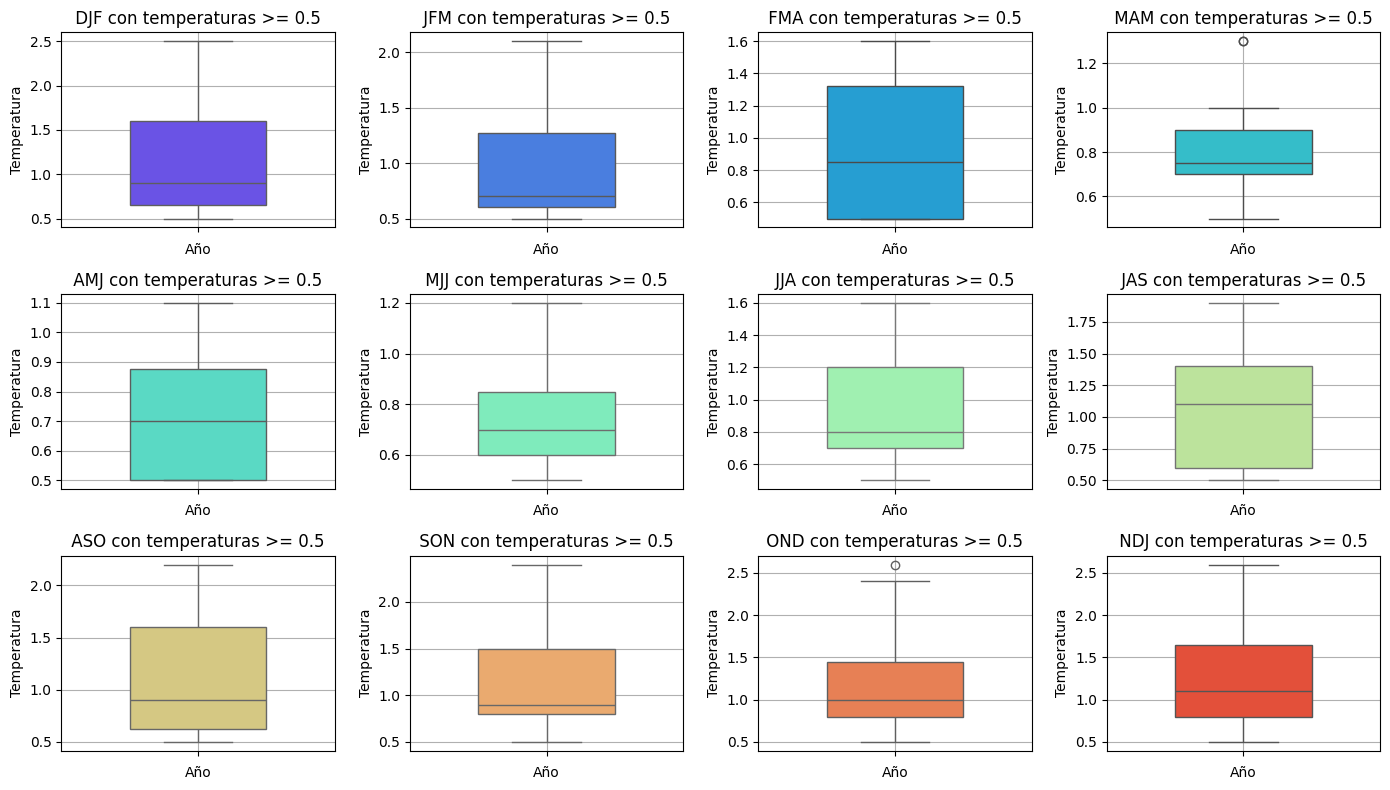

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir una función para filtrar las temperaturas por encima de 0.5 para cada mes
def filter_el_nino_data(dataframe):
    # Filtrar las temperaturas por encima de 0.5 para cada mes
    el_nino_data = dataframe[dataframe >= 0.5]
    # Colapsar los valores no nulos en una sola serie de tiempo
    el_nino_data = el_nino_data.melt(ignore_index=False)['value']
    # Eliminar los valores NaN resultantes
    el_nino_data = el_nino_data.dropna()
    return el_nino_data

# Crear un nuevo DataFrame con datos filtrados para El Niño
el_nino_temperatures_all_months = filter_el_nino_data(df.drop('Year', axis=1))

# Obtener la paleta de colores "rainbow" con la cantidad de colores igual al número de columnas - 1
palette = sns.color_palette("rainbow", len(df.columns[1:]))

# Crear boxplots para cada mes con temperaturas iguales o superiores a 0.5
plt.figure(figsize=(14, 8))
for i, column in enumerate(df.columns[1:], start=1):
    # Filtrar el conjunto de datos para el mes actual
    filtered_data = filter_el_nino_data(df[[column]])
    # Crear un boxplot para el mes actual con el color correspondiente de la paleta
    plt.subplot(3, 4, i)
    sns.boxplot(data=filtered_data, width=0.5, color=palette[i-1])  # Utilizar el color correspondiente de la paleta
    plt.xlabel('Año')
    plt.ylabel('Temperatura')
    plt.title(f' {column} con temperaturas >= 0.5 ')
    plt.grid(True)

plt.tight_layout()
plt.show()


## ENCAJE DE TAKENS

In [24]:
def find_optimal_delay(x, maxtau=12):
    mi = delay.dmi(x, maxtau=maxtau)
    diffmi = np.diff(mi)

    return np.where(diffmi > 0)[0][0]

In [25]:
max_periodic_dimension=11
max_periodic_time_delay=11
stride=1
temperatura = df.iloc[:, 1:].values.flatten()
tau,d= takens_embedding_optimal_parameters(temperatura, max_periodic_dimension, max_periodic_time_delay, stride)
print('Optimal time delay: ', tau,'\nOptimal dimension: ', d)


Optimal time delay:  9 
Optimal dimension:  7


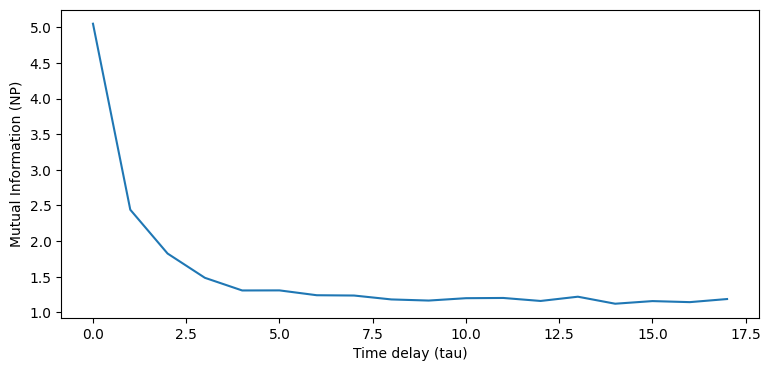

El primer mínimo local ocurre en: 4


In [26]:
plt.figure(figsize=(9,4))
plt.xlabel('Time delay (tau)')
plt.ylabel('Mutual Information (NP)')
plt.plot(delay.dmi(temperatura, maxtau=18))
plt.show()
print(f'El primer mínimo local ocurre en:',find_optimal_delay(temperatura, maxtau=18))


In [27]:
embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=4,
    dimension=2,
    stride=stride,
)

y_periodic_embedded = embedder_periodic.fit_transform(temperatura)
print(f"Shape of embedded time series: {y_periodic_embedded.shape}")

Shape of embedded time series: (896, 2)


In [28]:
plot_point_cloud(y_periodic_embedded)

### ANALISIS DE PERSISTENCIA POR MES

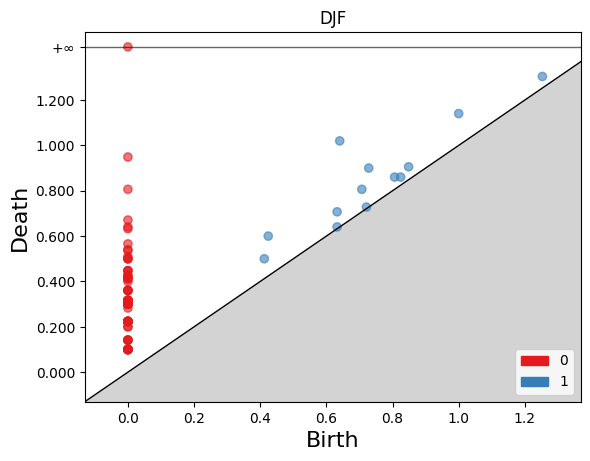

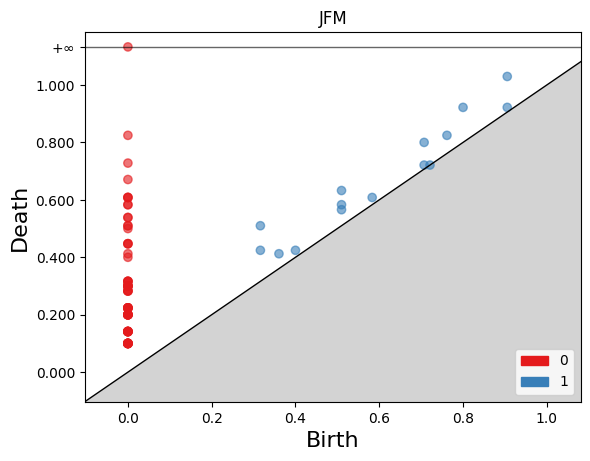

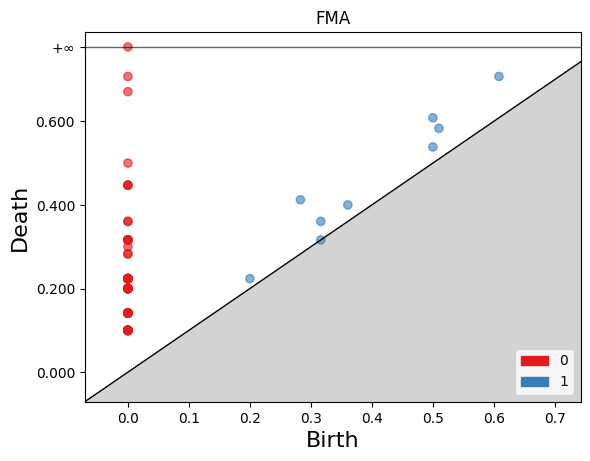

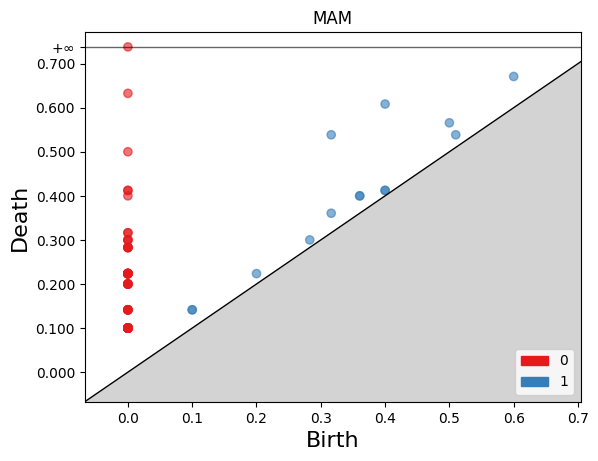

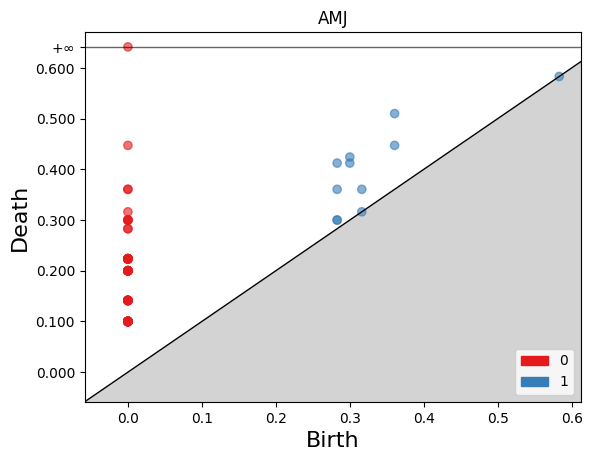

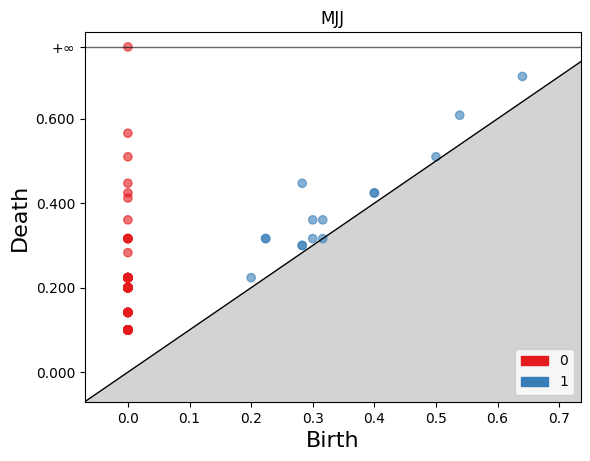

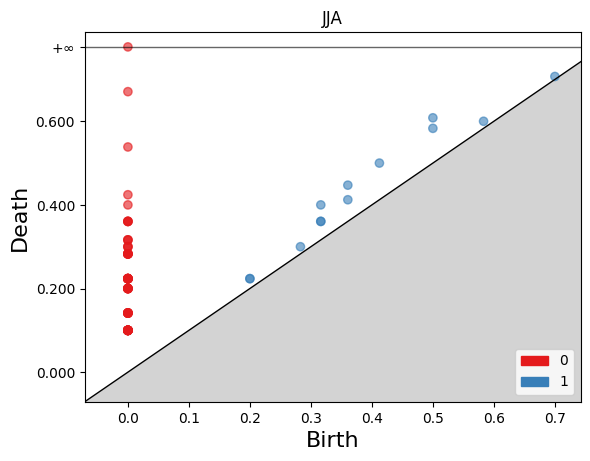

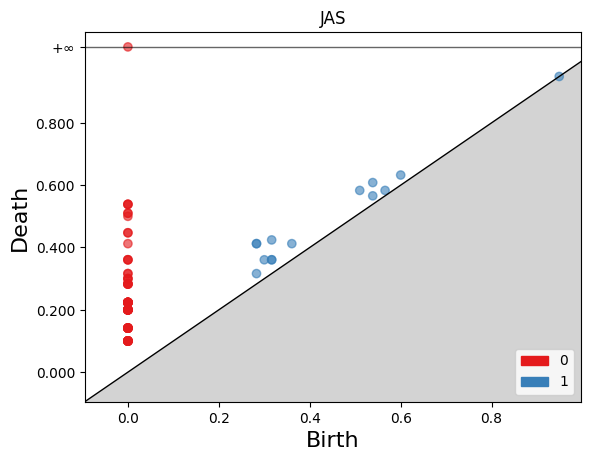

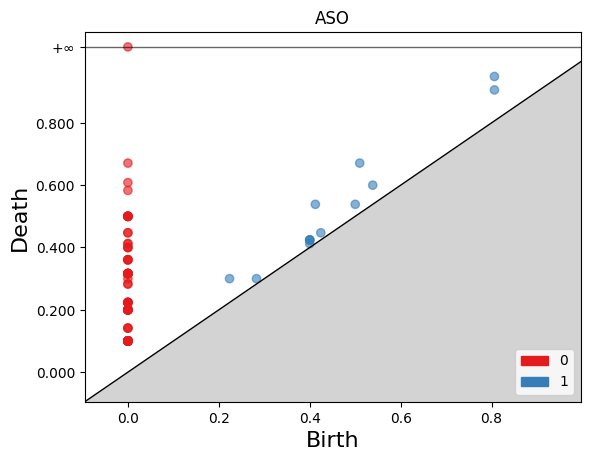

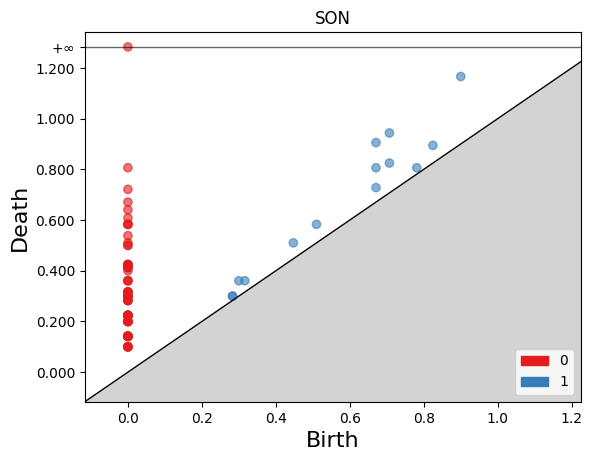

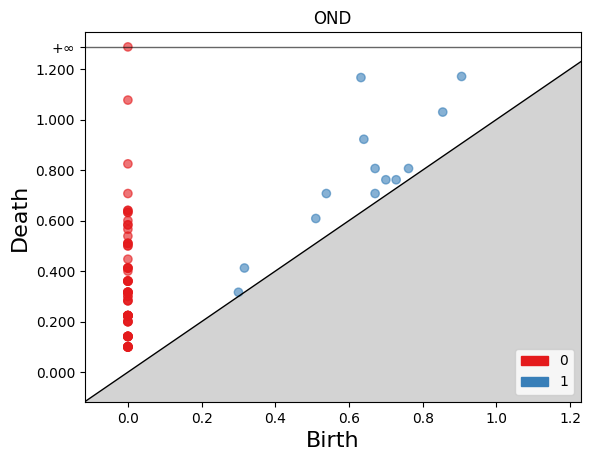

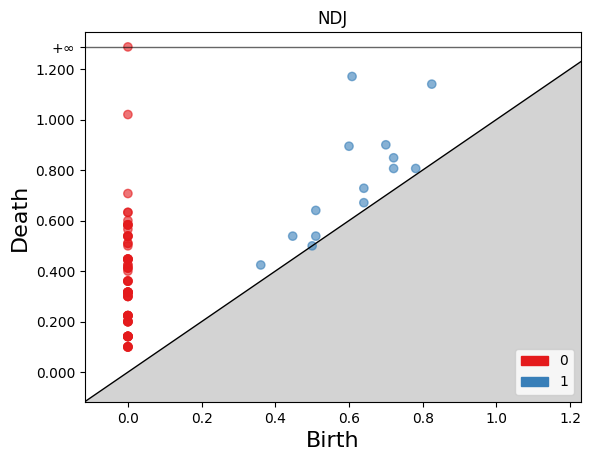

In [47]:


# Lista para almacenar los diagramas de persistencia por mes y por columna
persistencia_por_mes_y_columna = []
# Obtener la lista de meses únicos en los datos
unique_months = df['Year'].dt.month.unique()

# Iterar sobre cada columna de temperatura
for i, columna in enumerate(df.columns[1:]):

    # Lista para almacenar los diagramas de persistencia para esta columna
    persistencia_por_columna = []
    
    # Iterar sobre cada mes único
    for mes in unique_months:
        # Filtrar los datos para el mes actual
        datos_mes = df[df['Year'].dt.month == mes]
        # Extraer los datos de temperatura para este mes y esta columna
        temperatura_mes_columna = datos_mes[columna].values
        
        # Aplicar el encaje de Takens a los datos mensuales
        datos_encajados_mes = embedder_periodic.fit_transform(temperatura_mes_columna)
        
        # Calcular las persistencias para los datos encajados
        skeleton_mes = gd.RipsComplex(points=datos_encajados_mes, max_edge_length=2)
        simplex_tree_mes = skeleton_mes.create_simplex_tree(max_dimension=2)
        barcodes_mes = simplex_tree_mes.persistence()
        
        # Agregar el diagrama de persistencia a la lista
        persistencia_por_columna.append(barcodes_mes)
    
    # Graficar el diagrama de persistencia para esta columna en los ejes correspondientesaaa
    for persistencia_mes in persistencia_por_columna:
        # Crear el título con el nombre de la columna
        titulo = f"{columna}"
        
        # Crear la gráfica de persistencia con el título
        gd.plot_persistence_diagram(persistencia_mes)
        plt.title(titulo)
        plt.show()